In [1]:
from qutip import fock,  wigner, Qobj, ket2dm, qeye, fidelity, fock_dm, displace, destroy, create, squeeze
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import minimize
from scipy.special import factorial as fac
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
np.random.seed(42)

def plotState(dm, Qmax, points, numcut, name, fid=-1, filename='', step=None, log=False):
        """
        Qmax: highest quadrature value at the plot edge
        points: number of points in one axis from 0 out
        numcut: define the maximum photon number to show for the probability distribution
        """
        dpi = 300
        dx=Qmax/points
        xvec = np.arange(-points,points+1)*dx
        X,Y = np.meshgrid(xvec, xvec)
        W = wigner(Qobj(dm), xvec, xvec)
        fig = plt.figure(figsize=(16, 5), dpi=dpi )
        plt.rcParams.update({'font.size': 10})

        ax = fig.add_subplot(1, 3, 1)

        #define a surface plot and use vmin and vmax to set the limits of the colorscale to ensure the middle is at the origin
        p = ax.contourf(X, Y, W, 60, cmap=cm.RdBu, vmin=-1/np.pi,vmax=1/np.pi)
        ax.set_ylabel('P', fontsize=20)
        ax.set_xlabel('Q', fontsize=20)
        cb = fig.colorbar(p, shrink = 0.8) # add a colorbar

        ax.set_title("Wigner function of \n"+name+" state")

        # surface_plot with color grading and color bar
        ax = fig.add_subplot(1, 3, 2, projection='3d')
        p = ax.plot_surface(X, Y, W, rstride=1, cstride=1, cmap=cm.RdBu, vmin=-1/np.pi,vmax=1/np.pi, linewidth=0.5)
        ax.set_ylabel('P')
        ax.set_xlabel('Q')
        ax.set_title("Wigner function of \n"+name+" state")
        cb = fig.colorbar(p, shrink=.66, pad=0.05)
        ax = fig.add_subplot(1, 3, 3)
        probs = np.real(dm.diagonal()[0:numcut])
        avg = 0
        for i in range(numcut):
            avg += i*(probs[i])
        tr = sum(probs)
        p = ax.bar(range(numcut), probs)
        if numcut > 30:
           ax.set_xticks(range(0, numcut+1, 5))
        else:
            ax.set_xticks(range(0, numcut+1, 2))
        ax.set_ylabel('P(n)')
        ax.set_xlabel('n')
        if log:
           ax.set_yscale('log')
        ax.set_title("Photon number distribution of \n"+name+ " state\n" + r"$\langle n \rangle$: "+str(round(avg,4))+ "    Trace: "+str(round(tr,4)))
        fig.tight_layout()
        
        plt.savefig(filename+'.png', dpi=dpi)


# the (self) Kerr interaction 
def kerr(dim, kappa): 
    op = (1j*kappa*(create(dim)*destroy(dim))**2).expm()
    return op


def evolve(state, params, dim):
    for i in range(0, len(params), 2):
        d = min(np.abs(params[i]), 2.5)
        kappa = params[i+1]
        D = displace(dim, d)
        K = kerr(dim, kappa) 
        state =  K * D * state

    return state


def cost_NM(params):
    dim = 30
    state = fock(dim, 0)
    target = fock_dm(dim, 1) 
    state = evolve(state, params, dim)
    cost = fidelity(state, target)**2
    return(-cost)


def cost_BO(alpha1, kappa1, alpha2, kappa2,
               alpha3, kappa3, alpha4, kappa4):
    
    dim = 30
    state = fock(dim, 0)
    params = [ alpha1, kappa1, alpha2, kappa2,
               alpha3, kappa3, alpha4, kappa4
               ] 
    
    target = fock_dm(dim, 1) 
    state = evolve(state, params, dim)
    cost = fidelity(state, target)**2 
    return(cost)


def evolve_lossy(state, params, dim):

    for i in range(0, len(params), 2):
        d = min(np.abs(params[i]), 2.5)
        kappa = params[i+1]
        D = displace(dim, d)
        K = kerr(dim, kappa) 
        state =  K * D * state * D.dag() * K.dag() 

    state_lossy = 0 * fock_dm(dim, 0)
    eta = min( 0.35, np.abs(np.random.normal(loc=0, scale=0.1, size=(1,))[0]) ) # maximum loss is 35%
    a = destroy(dim)
    Ls =  [  np.sqrt( (eta**l)/(fac(l)*(1-eta)**l) ) * (a**l) * (0.5*a.dag()*a*np.log(1-eta)).expm()  for l in range(dim)  ]
    for L in Ls:
        state_lossy += L*state*L.dag()

    state_lossy /= state_lossy.tr() # normalize state since loss is non-unitary
    return state_lossy


def cost_NM_lossy(params):
    dim = 30
    state = fock_dm(dim, 0) # use density matrix since we are dealing with loss now
    target = fock_dm(dim, 1) 
    state = evolve_lossy(state, params, dim)
    
    cost = fidelity(state, target)**2
    return(-cost)


def cost_BO_lossy(alpha1, kappa1, alpha2, kappa2,
               alpha3, kappa3, alpha4, kappa4):
    
    dim = 30
    state = fock_dm(dim, 0) # use density matrix since we are dealing with loss now
    params = [ alpha1, kappa1, alpha2, kappa2,
               alpha3, kappa3, alpha4, kappa4
               ] 
    
    target = fock_dm(dim, 1) 
    state = evolve_lossy(state, params, dim)
    
    cost = fidelity(state, target)**2 
    return(cost)


# The target state

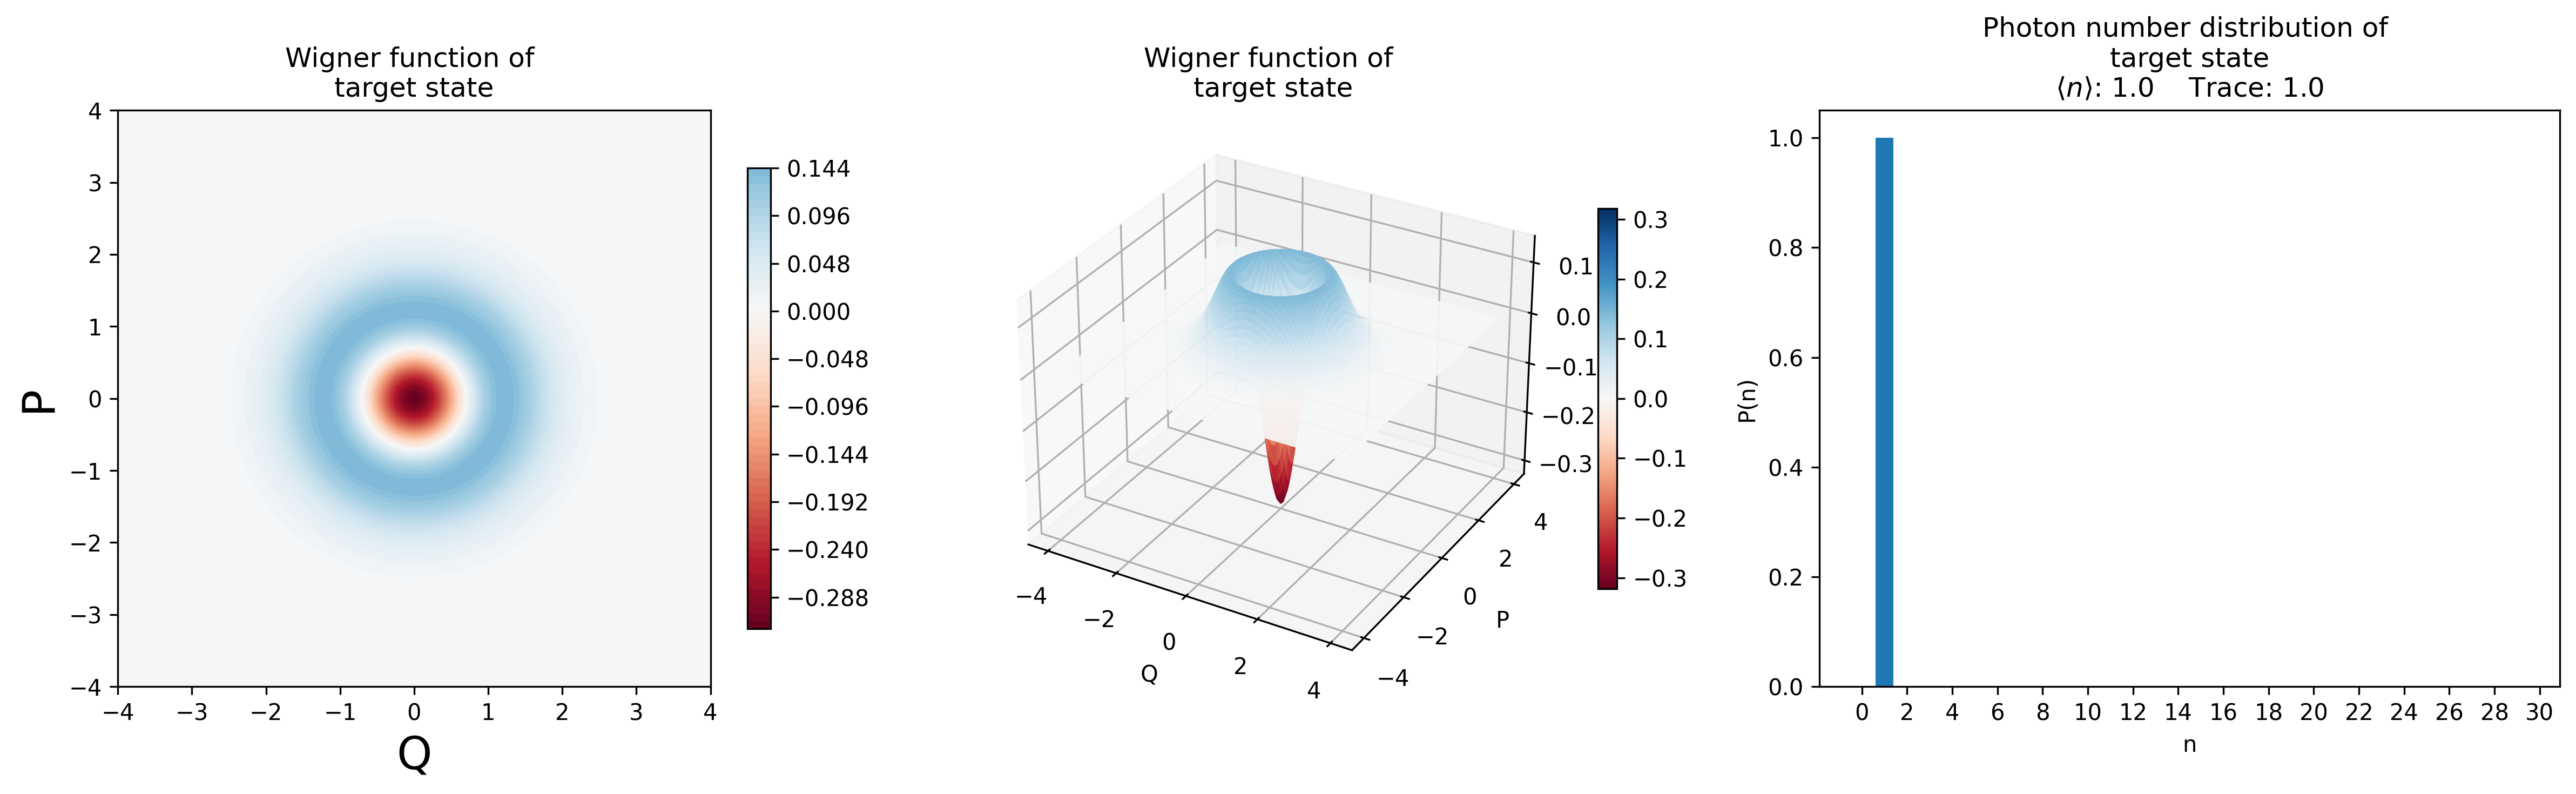

In [2]:
dim = 30
Qmax = 4
points = 50 * 1

kerr_max = 3
kerr_min = -3
disp_max = 2
disp_min = -2
max_evals_NM = 2000 

target = fock_dm(dim, 1) 

plotState(dm=np.array(target), Qmax=Qmax, points=points, numcut=dim, 
          name=r'target', fid=-1, filename='target')

# Noiseless case (no photon loss)

## Using the Nelder-Mead optimization algorithm

In [3]:
num_gates = 8
params_init = np.random.uniform(0.0, 1, (num_gates,))
res = minimize(cost_NM, params_init, method='nelder-mead',
              options={'maxfev': max_evals_NM} )

print(f'Optimal fidelity reached {-1*res.fun}')
print(f'Took {res.nfev} function evaluations')
print(f'Optimal parameters are {res.x}')

Optimal fidelity reached 0.9271225809769639
Took 446 function evaluations
Optimal parameters are [0.92765744 0.53113144 0.51753844 0.60327527 0.3475957  0.06489028
 0.04848118 0.95620984]


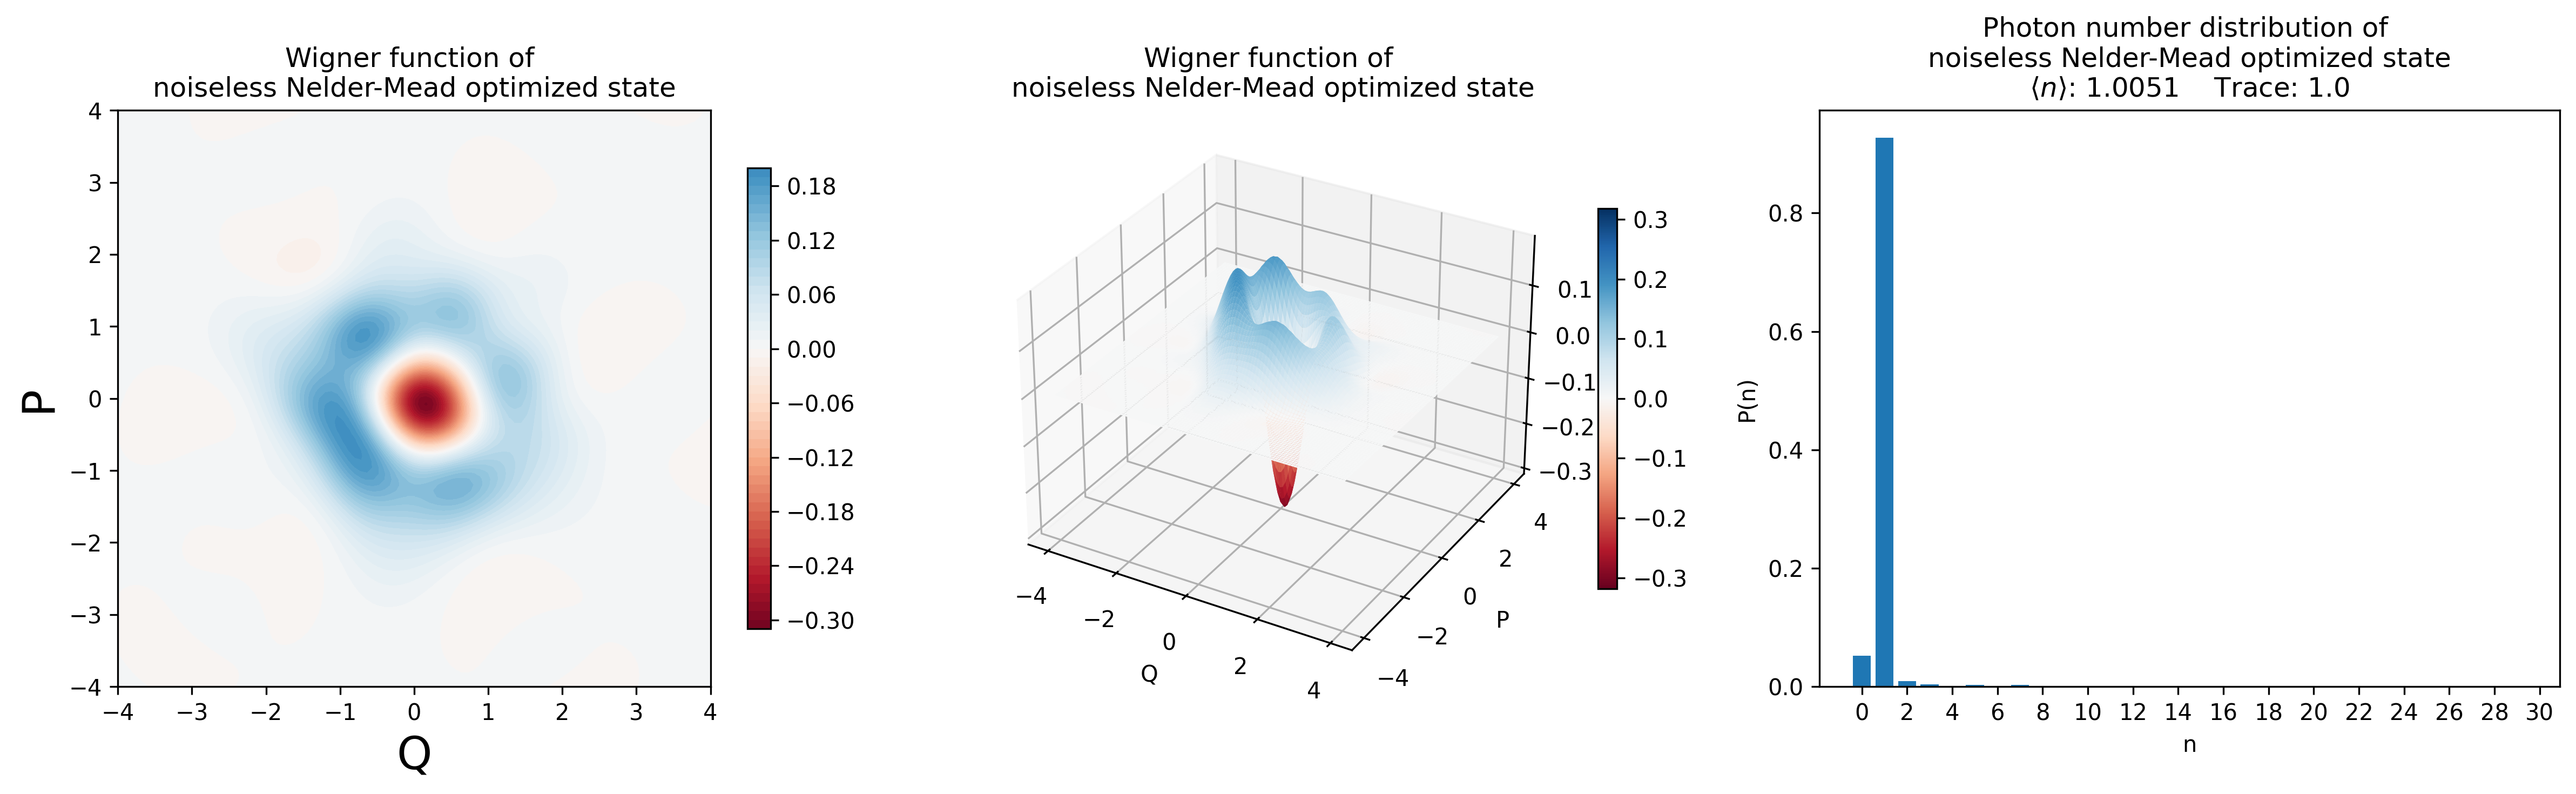

In [4]:
state = fock(dim, 0)
state = ket2dm( evolve(state, res.x, dim) )
plotState(dm=np.array(state), Qmax=Qmax, points=points, numcut=dim, 
          name=r'noiseless Nelder-Mead optimized', fid=-1, filename='NM')

## Using the Bayesian optimization algorithm

In [5]:
pbounds = {'alpha1': (disp_min, disp_max), 'kappa1': (kerr_min, kerr_max),
           'alpha2': (disp_min, disp_max), 'kappa2': (kerr_min, kerr_max),
           'alpha3': (disp_min, disp_max), 'kappa3': (kerr_min, kerr_max),
           'alpha4': (disp_min, disp_max), 'kappa4': (kerr_min, kerr_max),
		   }

optimizer = BayesianOptimization(
    f=cost_BO,
    pbounds=pbounds,
    verbose=1,
    random_state=4,
)

acquisition_function = UtilityFunction(kind="ucb", kappa=0.5)

optimizer.maximize(
    init_points=50,
    n_iter=150,
	acquisition_function=acquisition_function
)


|   iter    |  target   |  alpha1   |  alpha2   |  alpha3   |  alpha4   |  kappa1   |  kappa2   |  kappa3   |  kappa4   |
-------------------------------------------------------------------------------------------------------------------------
| 2         | 0.4603    | -0.9881   | -0.2608   | 1.118     | -1.209    | 2.178     | 2.9       | -2.017    | 0.584     |
| 13        | 0.6207    | -0.1095   | -0.4289   | 0.4757    | -0.2529   | -1.434    | -0.5252   | -0.4858   | 2.415     |
| 52        | 0.6592    | -0.09363  | -0.5129   | 0.3753    | -0.2787   | -1.361    | -0.4498   | -0.4795   | 2.458     |
| 54        | 0.7181    | -0.1824   | -0.6179   | 0.31      | -0.3495   | -1.356    | -0.4063   | -0.5987   | 2.353     |
| 57        | 0.7553    | -0.1739   | -0.6568   | 0.3114    | -0.3972   | -1.435    | -0.3785   | -0.4689   | 2.313     |
| 59        | 0.8463    | 0.05128   | -0.7742   | 0.3585    | -0.437    | -1.465    | -0.4475   | -0.4984   | 2.25      |
| 70        | 0.8747    

In [6]:
res = optimizer.max
params = [ res['params']['alpha1'], res['params']['kappa1'], res['params']['alpha2'], res['params']['kappa2'],
		   res['params']['alpha3'], res['params']['kappa3'], res['params']['alpha4'], res['params']['kappa4'],
            ]  

state = fock(dim, 0)
state = ket2dm( evolve(state, params, dim) )
print(f'Optimal fidelity reached { fidelity(state, target)**2 }')
print(f'Took {len(optimizer.res)} function evaluations')
print(f'Optimal parameters are {params}')

Optimal fidelity reached 0.905426980181397
Took 200 function evaluations
Optimal parameters are [0.03409239960391907, -1.3293568009014234, -0.7926068457588832, -0.47851116431837026, 0.5493309869707793, -0.6107012532359634, -0.41673351622225474, 2.358557924482399]


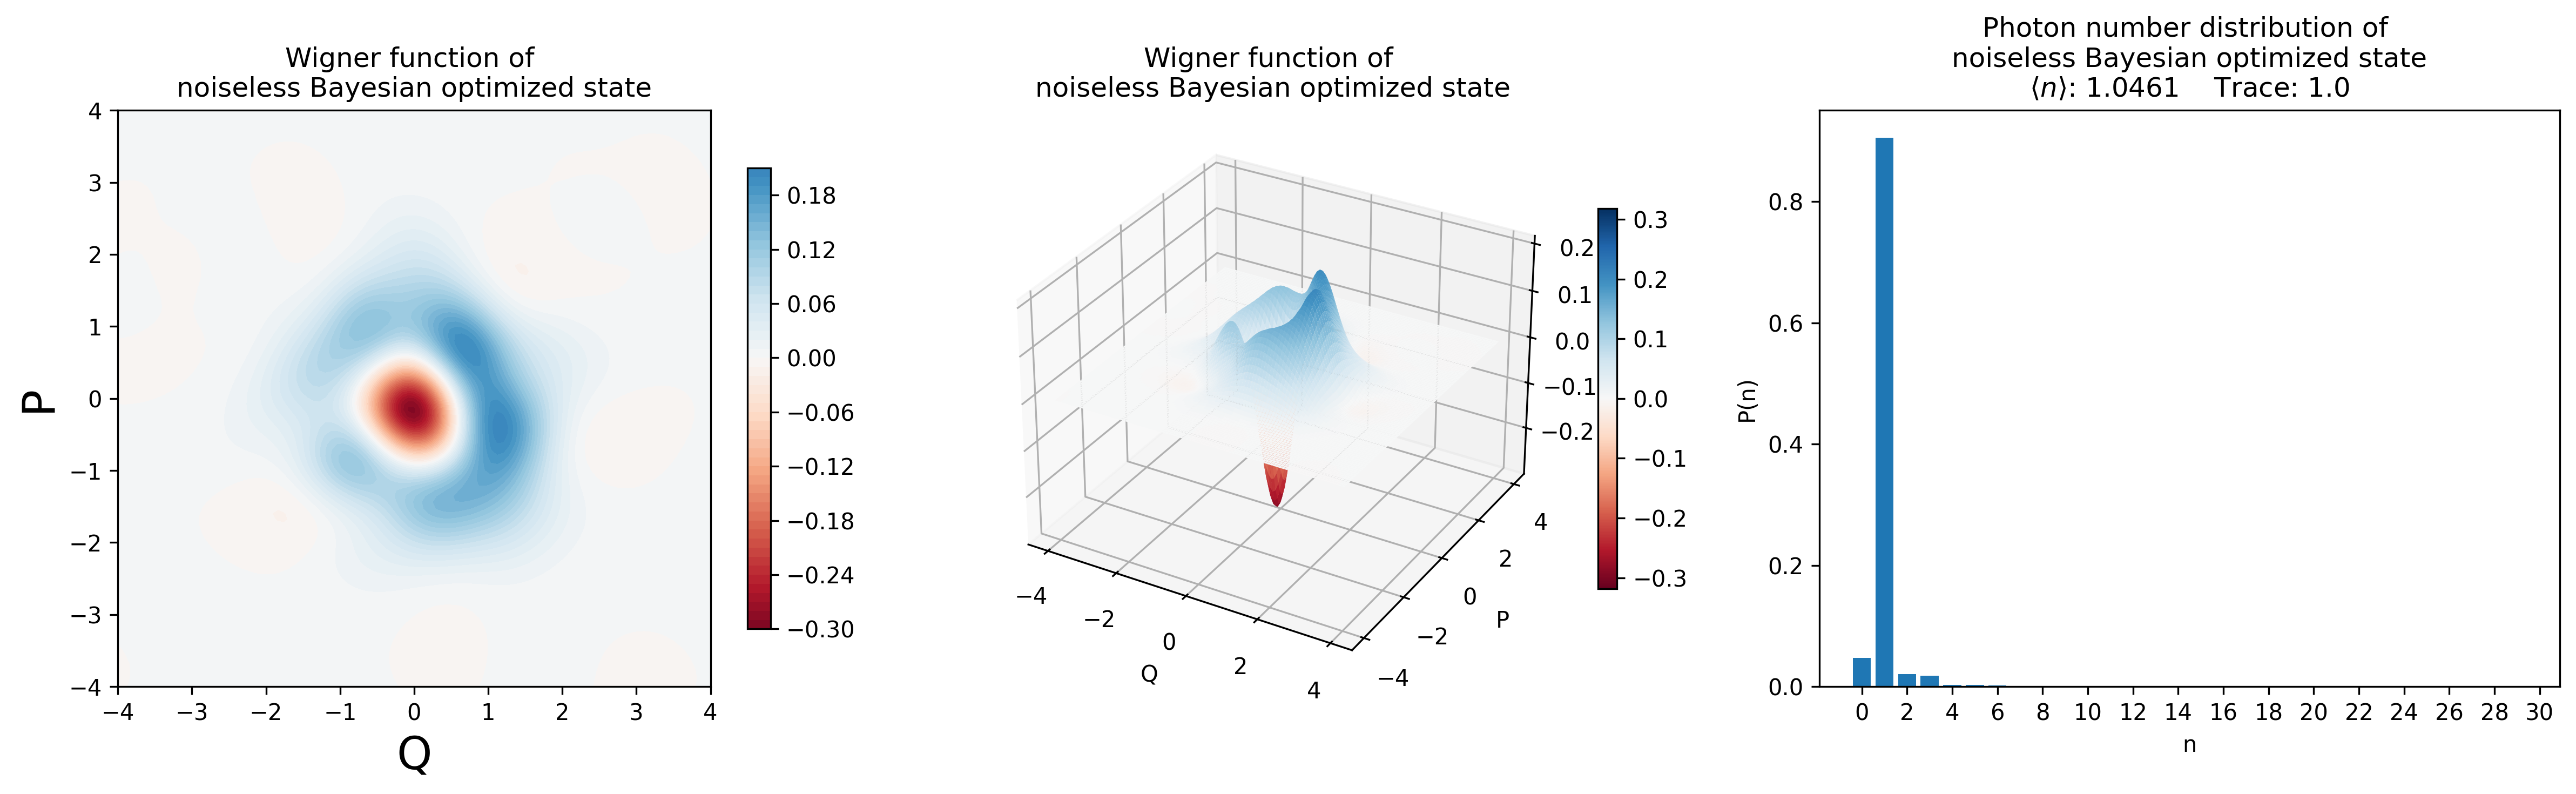

In [7]:
plotState(dm=np.array(state), Qmax=Qmax, points=points, numcut=dim, 
          name=r'noiseless Bayesian optimized', fid=-1, filename='BO')

# Adding noise to the objective function (photon loss)

## Using the Nelder-Mead optimization algorithm

In [8]:
params_init = np.random.uniform(0.0, 1, (num_gates,))
res = minimize(cost_NM_lossy, params_init, method='nelder-mead',
              options={ 'maxfev' : max_evals_NM} )

print(f'Took {res.nfev} function evaluations')
print(f'Optimal parameters are {res.x}')

Took 2000 function evaluations
Optimal parameters are [0.59535593 0.73524677 0.02048878 0.98572458 0.84764194 0.21453114
 0.18209384 0.18266636]


Optimal fidelity reached 0.19993244925613723


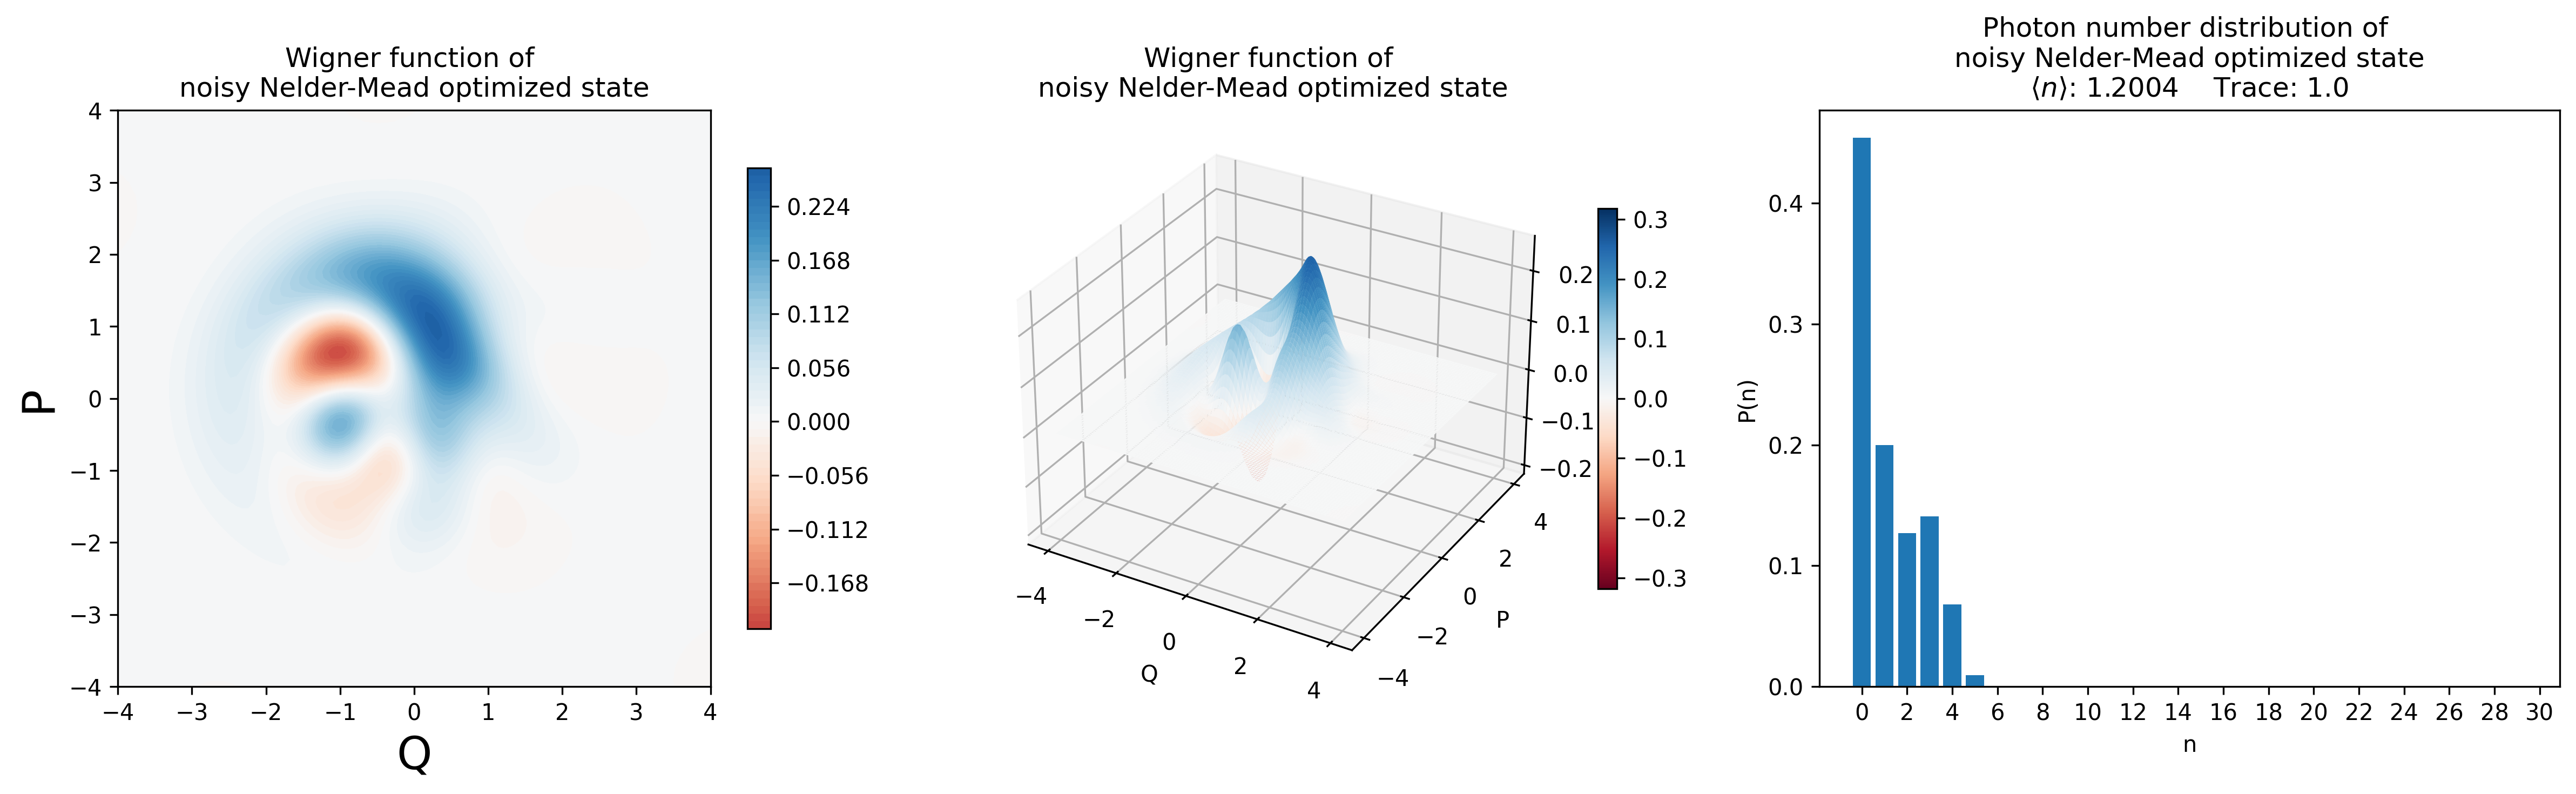

In [9]:
state = fock(dim, 0)
state = ket2dm( evolve(state, res.x, dim) )
print(f'Optimal fidelity reached { fidelity(state, target)**2 }')
plotState(dm=np.array(state), Qmax=Qmax, points=points, numcut=dim, 
          name=r'noisy Nelder-Mead optimized', fid=-1, filename='NM_lossy')

## Using the Bayesian optimization algorithm

In [10]:
optimizer = BayesianOptimization(
    f=cost_BO_lossy,
    pbounds=pbounds,
    verbose=1,
    random_state=4
)

acquisition_function = UtilityFunction(kind="ucb", kappa=1.65)

optimizer.maximize(
    init_points=50,
    n_iter=150,
	acquisition_function=acquisition_function
)


|   iter    |  target   |  alpha1   |  alpha2   |  alpha3   |  alpha4   |  kappa1   |  kappa2   |  kappa3   |  kappa4   |
-------------------------------------------------------------------------------------------------------------------------
| 2         | 0.4553    | -0.9881   | -0.2608   | 1.118     | -1.209    | 2.178     | 2.9       | -2.017    | 0.584     |
| 13        | 0.4662    | -0.1095   | -0.4289   | 0.4757    | -0.2529   | -1.434    | -0.5252   | -0.4858   | 2.415     |
| 47        | 0.4963    | 0.8976    | 0.619     | -0.5068   | 1.214     | 1.17      | -0.04876  | 0.4315    | 2.694     |
| 58        | 0.5086    | 0.4245    | -0.7077   | 0.5778    | -0.1858   | -1.224    | -0.7228   | -0.2183   | 2.522     |
| 64        | 0.5929    | 0.1946    | -0.5784   | 0.586     | -0.2165   | -1.356    | -0.6823   | -0.3492   | 2.44      |
| 65        | 0.6158    | 0.2661    | -0.564    | 0.6594    | -0.2266   | -1.417    | -0.6369   | -0.4686   | 2.599     |
| 69        | 0.7135    

In [11]:
res = optimizer.max
params = [ res['params']['alpha1'], res['params']['kappa1'], res['params']['alpha2'], res['params']['kappa2'],
		   res['params']['alpha3'], res['params']['kappa3'], res['params']['alpha4'], res['params']['kappa4']
            ] 

state = fock(dim, 0)
state = ket2dm( evolve(state, params, dim) )
print(f'Optimal fidelity reached { fidelity(state, target)**2 }')
print(f'Took {len(optimizer.res)} function evaluations')
print(f'Optimal parameters are {params}')

Optimal fidelity reached 0.9118234893327045
Took 200 function evaluations
Optimal parameters are [0.2967570120455048, -0.09784659975144545, -0.4765390923070279, 0.9171952773574962, 0.6695636674623962, -0.9233087245437402, -0.3414336232969048, 2.900752697896855]


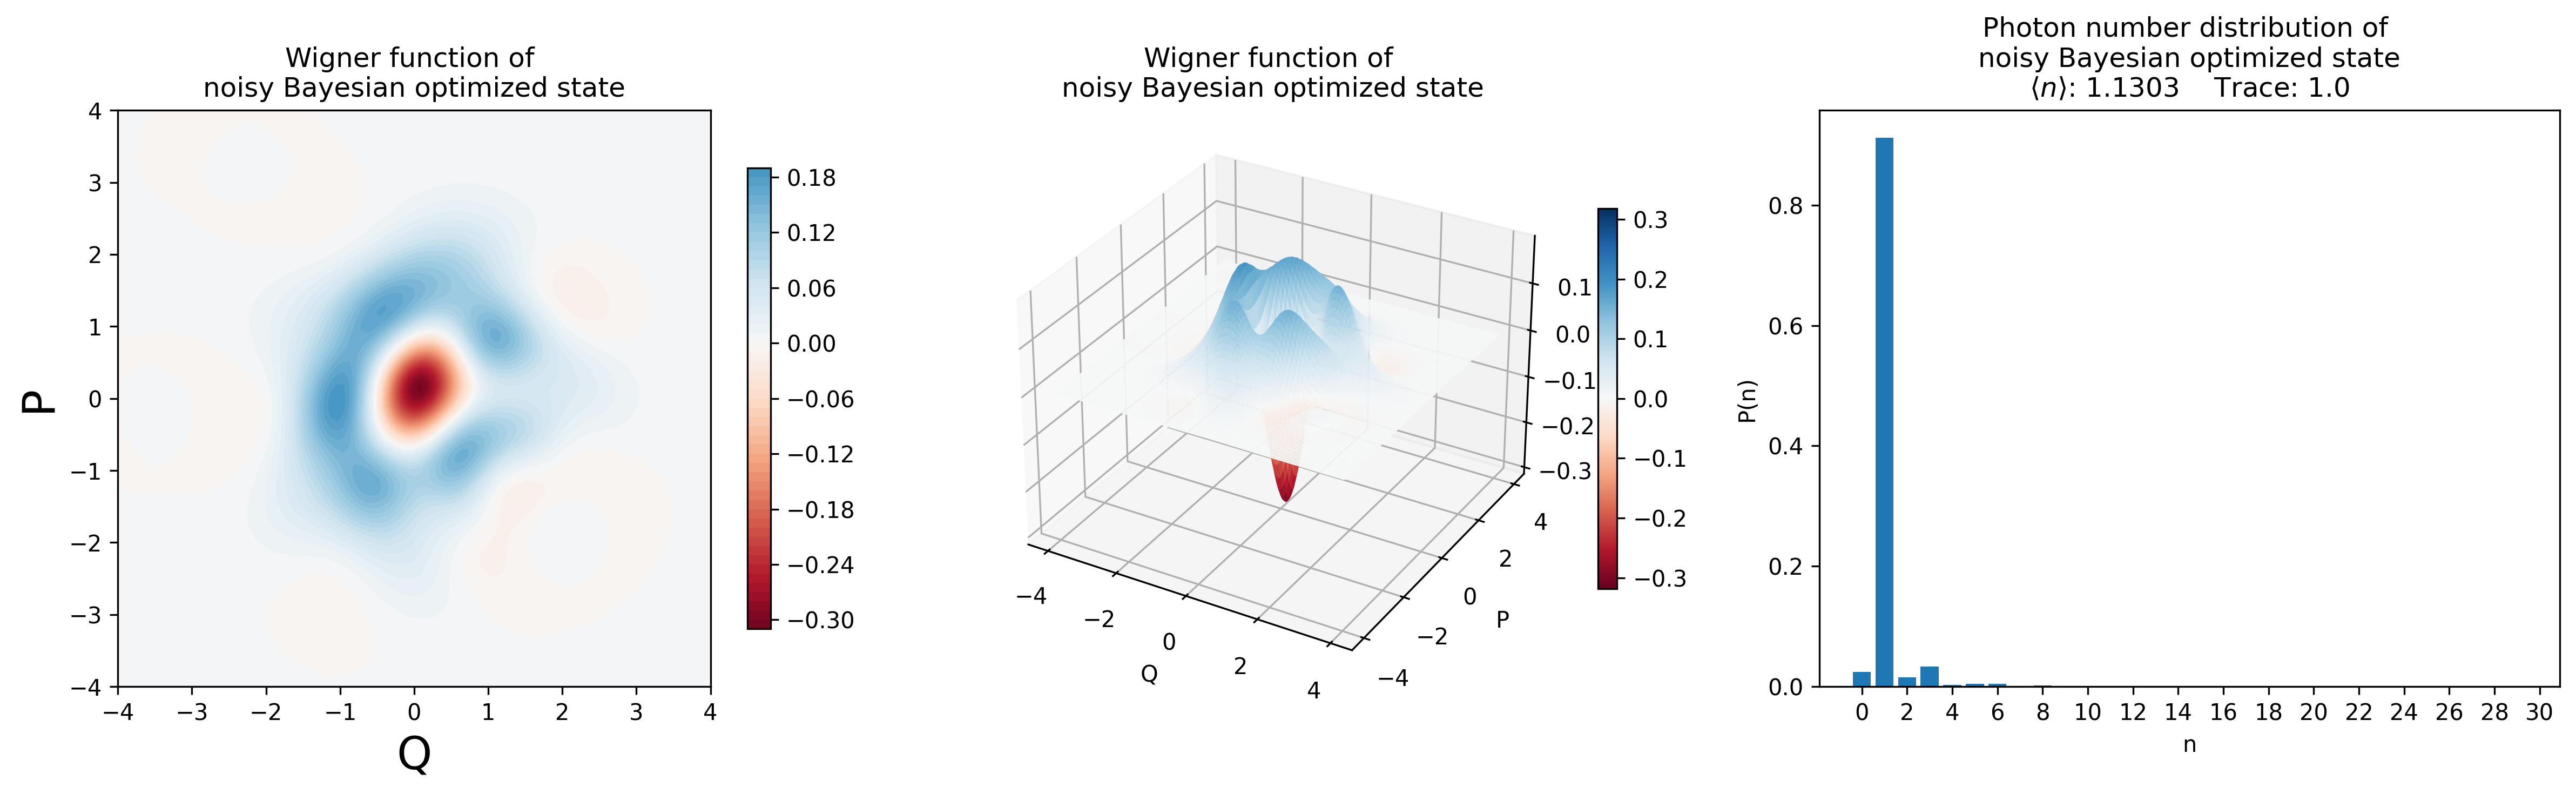

In [12]:
plotState(dm=np.array(state), Qmax=Qmax, points=points, numcut=dim, 
          name=r'noisy Bayesian optimized', fid=-1, filename='BO_lossy')